# Forecast Error Metrics: Definitions, Optimization, and Optimal Forecasters

Here we compare multiple error metrics for CPC forecast performance, including their definitions, what they optimize for, and mathematical derivations of their optimal forecasters.

---

## 1. Mean Absolute Percentage Error (MAPE)

### Definition
MAPE measures the average absolute percentage difference between actual and forecasted values:

$$\text{MAPE} = \frac{1}{n} \sum_{t=1}^{n} \left| \frac{y_t - \hat{y}_t}{y_t} \right| \times 100\%$$

where $y_t$ is the actual value and $\hat{y}_t$ is the forecasted value.

### What it optimizes for
MAPE optimizes for **relative accuracy** - it penalizes errors proportionally to the actual values. Large errors on small values are heavily penalized, while the same absolute error on large values is less penalized. This makes it scale-independent and useful for comparing forecasts across different magnitudes.

### Optimal forecaster
The optimal forecaster for MAPE is the **median** of the forecast distribution.

**Mathematical proof:**
To minimize $E\left[\left|\frac{Y - c}{Y}\right|\right]$ where $c$ is our forecast:

Taking the derivative with respect to $c$:
$$\frac{d}{dc} E\left[\left|\frac{Y - c}{Y}\right|\right] = E\left[\text{sign}\left(\frac{Y - c}{Y}\right) \cdot \left(-\frac{1}{Y}\right)\right]$$

Setting equal to zero:
$$E\left[\frac{\text{sign}(Y - c)}{Y}\right] = 0$$

This condition is satisfied when $c$ equals the weighted median of $Y$, where weights are $\frac{1}{|Y|}$.

---

## 2. Mean Absolute Error (MAE)

### Definition
MAE measures the average absolute difference between actual and forecasted values:

$$\text{MAE} = \frac{1}{n} \sum_{t=1}^{n} |y_t - \hat{y}_t|$$

### What it optimizes for
MAE optimizes for **absolute accuracy** with equal weight given to all errors regardless of magnitude. It's robust to outliers since it doesn't square the errors, making it suitable when you want to minimize typical forecast errors without being overly influenced by extreme values.

### Optimal forecaster
The optimal forecaster for MAE is the **median** of the forecast distribution.

**Mathematical proof:**
To minimize $E[|Y - c|]$ where $c$ is our forecast:

The derivative of $|Y - c|$ with respect to $c$ is:
$$\frac{d}{dc}|Y - c| = -\text{sign}(Y - c)$$

Taking expectation:
$$\frac{d}{dc}E[|Y - c|] = -E[\text{sign}(Y - c)]$$

Setting equal to zero:
$$E[\text{sign}(Y - c)] = 0$$

This means $P(Y > c) = P(Y < c) = 0.5$, which defines $c$ as the median of $Y$.

---

## 3. Mean Squared Error (MSE)

### Definition
MSE measures the average squared difference between actual and forecasted values:

$$\text{MSE} = \frac{1}{n} \sum_{t=1}^{n} (y_t - \hat{y}_t)^2$$

### What it optimizes for
MSE optimizes for **minimizing large errors** by squaring deviations. It heavily penalizes outliers and large forecast errors while being relatively lenient on small errors. This makes it suitable when large errors are particularly costly or problematic.

### Optimal forecaster
The optimal forecaster for MSE is the **mean** of the forecast distribution.

**Mathematical proof:**
To minimize $E[(Y - c)^2]$ where $c$ is our forecast:

Expanding:
$$E[(Y - c)^2] = E[Y^2 - 2cY + c^2] = E[Y^2] - 2cE[Y] + c^2$$

Taking the derivative with respect to $c$:
$$\frac{d}{dc}E[(Y - c)^2] = -2E[Y] + 2c$$

Setting equal to zero:
$$-2E[Y] + 2c = 0$$
$$c = E[Y]$$

Therefore, the mean minimizes MSE.

---

## 4. Root Mean Squared Error (RMSE)

### Definition
RMSE is the square root of MSE, bringing the error metric back to the same units as the original data:

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{t=1}^{n} (y_t - \hat{y}_t)^2} = \sqrt{\text{MSE}}$$

### What it optimizes for
RMSE optimizes for the same objective as MSE (minimizing large errors) but expresses the result in the original units of measurement. Like MSE, it penalizes large errors more heavily than small ones due to the squaring operation.

### Optimal forecaster
The optimal forecaster for RMSE is also the **mean** of the forecast distribution.

**Mathematical proof:**
Since RMSE = $\sqrt{\text{MSE}}$, and the square root function is monotonically increasing:

$$\arg\min_c \text{RMSE} = \arg\min_c \sqrt{\text{MSE}} = \arg\min_c \text{MSE}$$

Therefore, the optimal forecaster for RMSE is the same as for MSE: the mean.

---

## 5. Mean Error (ME)

### Definition
ME measures the average difference (without absolute value) between actual and forecasted values:

$$\text{ME} = \frac{1}{n} \sum_{t=1}^{n} (y_t - \hat{y}_t)$$

### What it optimizes for
ME optimizes for **bias detection** rather than accuracy. Positive ME indicates systematic under-forecasting, while negative ME indicates systematic over-forecasting. It doesn't measure forecast accuracy since positive and negative errors can cancel out.

### Optimal forecaster
The optimal forecaster for ME (in terms of minimizing bias) is the **mean** of the forecast distribution.

**Mathematical proof:**
To minimize $E[Y - c]$ where $c$ is our forecast:

$$\frac{d}{dc}E[Y - c] = \frac{d}{dc}(E[Y] - c) = -1$$

Since the derivative is always -1 (negative), ME decreases as $c$ increases. However, for practical purposes, we want ME = 0 (no bias):

Setting $E[Y - c] = 0$:
$$E[Y] - c = 0$$
$$c = E[Y]$$

Therefore, the mean provides an unbiased forecaster (ME = 0).

---

## Summary Table

| Metric | Optimal Forecaster | Optimizes For | Outlier Sensitivity |
|--------|-------------------|---------------|-------------------|
| MAPE   | Weighted Median   | Relative accuracy | Medium |
| MAE    | Median           | Absolute accuracy | Low |
| MSE    | Mean             | Large error penalty | High |
| RMSE   | Mean             | Large error penalty (original units) | High |
| ME     | Mean             | Bias detection | Medium |


In [3]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import os
import pandas_gbq
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext bigquery_magics 
BQ_PROJECT_ID = "dhh-ncr-stg"

CURRENT_DIR = Path(os.getcwd())
BASE_QUERY_PATH = CURRENT_DIR.parent / "queries"
CANDIDATE_SQL_PATH = BASE_QUERY_PATH / "data_collection.sql"

PLOT_PATH = CURRENT_DIR.parent / "figures"

SEED = 13
rng = np.random.default_rng(SEED)

The bigquery_magics extension is already loaded. To reload it, use:
  %reload_ext bigquery_magics


In [ ]:
try:
    with open(CANDIDATE_SQL_PATH, 'r') as file:
        candidate_query = file.read()
    print(f"Loaded SQL query: {len(candidate_query)} characters")
except FileNotFoundError:
    print("SQL file not found")
except IOError:
    print("Error reading the file")

reco_sources = ['CEB', 'ML']
booking_sources = ['agent', 'vendor']

output = []
for rs in reco_sources:
    for bs in booking_sources:
        tmp = (
            pandas_gbq.read_gbq(
                candidate_query.format(RECO_SOURCE=rs, BOOKING_SOURCE=bs), 
                project_id=BQ_PROJECT_ID
            )
        )
        output.append(tmp)

df = pd.concat(output)

Loaded SQL query: 6260 characters
Downloading: 100%|██████████|


In [4]:
df.head()

,reco_source,booking_source,global_entity_id,vendor_id,date_month,management_entity,campaign_id,booked_budget,cpc_clicks,cpc_orders,...,bid_eur,k_c,b_c,k_o,b_o,k_r,b_r,adj_e_clicks,adj_e_orders,adj_e_roas
0,CEB,agent,TB_OM,644347,2025-06-01,Talabat,6857a5c52ae08ceb41363f76,267.000000000,360,88,...,0.74,2.586207,-18.965517,0.189655,-1.724138,0.0,3.0,671.551724,48.913793,3.0
1,CEB,agent,TB_OM,710055,2025-06-01,Talabat,6855578646f1a2a33f6233e8,361.000000000,0,0,...,NaN,2.586207,-18.965517,0.189655,-1.724138,0.0,3.0,914.655172,66.741379,3.0
2,CEB,agent,PO_FI,ls67,2025-06-01,DH Europe,684946074e85dc5e560be0f0,200.000000000,121,19,...,1.67,0.833333,-33.333333,0.100000,-5.000000,0.0,3.0,133.333333,15.000000,3.0
3,CEB,agent,NP_HU,lqya,2025-06-01,DH Europe,68396bf11e043dddccec33d1,248.000000000,1430,95,...,0.19,1.606426,-31.626506,0.092369,-2.506024,0.0,3.0,366.767068,20.401606,3.0
4,CEB,agent,NP_HU,xy7n,2025-06-01,DH Europe,683da30bb0ff6d31a484f738,149.000000000,307,64,...,0.48,0.791139,88.449367,0.120253,14.044304,0.0,3.0,206.329114,31.962025,3.0


In [5]:
# this is weird. crazy high predictions. the largest has predicted clicks higher than all observed clicks.
# I am going to delete these. They are CEB only. We are interested here in comparing metrics. I don't think this will affect the discussion.
df.loc[df.adj_e_clicks < df.groupby(['global_entity_id', 'vendor_id']).cpc_clicks.sum().max() * 10]

,reco_source,booking_source,global_entity_id,vendor_id,date_month,management_entity,campaign_id,booked_budget,cpc_clicks,cpc_orders,...,bid_eur,k_c,b_c,k_o,b_o,k_r,b_r,adj_e_clicks,adj_e_orders,adj_e_roas
0,CEB,agent,TB_OM,644347,2025-06-01,Talabat,6857a5c52ae08ceb41363f76,267.000000000,360,88,...,0.74,2.586207,-18.965517,0.189655,-1.724138,0.000000,3.000000,671.551724,48.913793,3.000000
1,CEB,agent,TB_OM,710055,2025-06-01,Talabat,6855578646f1a2a33f6233e8,361.000000000,0,0,...,NaN,2.586207,-18.965517,0.189655,-1.724138,0.000000,3.000000,914.655172,66.741379,3.000000
2,CEB,agent,PO_FI,ls67,2025-06-01,DH Europe,684946074e85dc5e560be0f0,200.000000000,121,19,...,1.67,0.833333,-33.333333,0.100000,-5.000000,0.000000,3.000000,133.333333,15.000000,3.000000
3,CEB,agent,NP_HU,lqya,2025-06-01,DH Europe,68396bf11e043dddccec33d1,248.000000000,1430,95,...,0.19,1.606426,-31.626506,0.092369,-2.506024,0.000000,3.000000,366.767068,20.401606,3.000000
4,CEB,agent,NP_HU,xy7n,2025-06-01,DH Europe,683da30bb0ff6d31a484f738,149.000000000,307,64,...,0.48,0.791139,88.449367,0.120253,14.044304,0.000000,3.000000,206.329114,31.962025,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,ML,vendor,PY_CL,537880,2025-06-01,Pedidosya,684a0e483dcb5e3e3678bf0e,33.000000000,179,1,...,0.18,2.773925,-1.000000,0.277393,-1.000000,-0.004574,3.505334,90.539528,8.153953,3.354379
514,ML,vendor,PY_CR,315169,2025-06-01,Pedidosya,6860dbbedc3564b86810b034,54.000000000,99,5,...,0.10,3.668523,10.000000,0.262037,0.000000,-0.012947,5.029325,208.100229,14.150016,4.330192
515,ML,vendor,PY_DO,491609,2025-06-01,Pedidosya,684aec7a40e7f028ec8d2749,44.000000000,230,15,...,0.22,1.456618,115.000000,0.189994,14.000000,-0.018079,7.934169,179.091197,22.359721,7.138700
516,ML,vendor,PY_EC,482913,2025-06-01,Pedidosya,68430d453f852ac4220c8a0b,53.000000000,662,69,...,0.08,1.827263,269.500000,0.170545,26.500000,-0.033273,6.883653,366.344926,35.538860,5.120158


In [6]:
df = df.loc[df.adj_e_clicks < df.groupby(['global_entity_id', 'vendor_id']).cpc_clicks.sum().max() * 10]

Relevant part of query, where `adj` is the table above

```
ape_t as (
SELECT *,
  SAFE_DIVIDE(ABS(cpc_clicks - adj_e_clicks) , cpc_clicks) * 100 as ape_c, 
  ... 
FROM adj
),

cl_groups as (
SELECT *,
   IF(cpc_clicks < 100, "<100", ">100")  as clicks_group 
FROM ape_t
)

SELECT 
  management_entity,
  clicks_group,
  ...
  ROUND(AVG(ape_c), 0) as MAPE_clicks,
  ...
FROM cl_groups 
```

Note, that we're using `SAFE_DIVIDE`, [which returns null](https://cloud.google.com/bigquery/docs/reference/standard-sql/mathematical_functions#safe_divide) when the denominator is zero. This means we don't include vendors with zero clicks in their forecast, even if they're relevant.

In [10]:
df['poisson_clicks'] = np.array(rng.poisson(df.cpc_clicks.values))

In [11]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)


def calculate_metrics(actual, predicted, weights):
    """Calculates and returns a dictionary of evaluation metrics."""
    if len(actual) == 0:
        return {'MAE': np.nan, 'MSE': np.nan, 'MAPE': np.nan, 'RMSE': np.nan}
    
    metrics = {
        'MAE': mean_absolute_error(actual, predicted),
        'weighted MAE': mean_absolute_error(actual, predicted, sample_weight=weights),
        'MSE': mean_squared_error(actual, predicted),
        'weighted MSE': mean_squared_error(actual, predicted, sample_weight=weights),
        'MAPE': mean_absolute_percentage_error(actual, predicted) * 100,
        'weighted MAPE': mean_absolute_percentage_error(actual, predicted, sample_weight=weights) * 100,
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'weighted RMSE': np.sqrt(mean_squared_error(actual, predicted, sample_weight=weights)),
        'ME': np.mean(actual - predicted),
        'weighted ME': np.average(actual - predicted, weights=weights)
    }
    return metrics

results_list = []

def generate_metrics_df(df, prediction_column, cutting_column='cpc_clicks'):
    """
    Calculates tiered and overall metrics for a given prediction column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        prediction_column (str): The name of the column with predicted values.
        cutting_column (str): The name of the column with values to be cut

    Returns:
        pd.DataFrame: A long-format DataFrame with metrics.
    """
    results_list = []
    bins = [-np.inf, 100, np.inf]
    labels = ['<100', '>=100']

    grouped = df.groupby(['reco_source', 'booking_source'])

    for (reco_source, booking_source), group_df in grouped:
        for subset_name, data_subset in [
            ('all_clicks', group_df),
            ('nonzero_clicks', group_df[group_df['cpc_clicks'] > 0])
        ]:
            if data_subset.empty:
                continue

            # Calculate Overall metrics
            overall_metrics = calculate_metrics(data_subset['cpc_clicks'].values, 
                                                data_subset[prediction_column].values,
                                                data_subset['cpc_revenue'].values)
            for metric_name, value in overall_metrics.items():
                results_list.append({
                    'predictor': prediction_column, 
                    'reco_source': reco_source,
                    'booking_source': booking_source,
                    'data_subset': subset_name,
                    'tier': 'Overall',
                    'metric': metric_name,
                    'value': value
                })

            # Calculate Tiered metrics
            data_subset = data_subset.copy()
            data_subset['tier'] = pd.cut(data_subset[cutting_column], bins=bins, labels=labels, right=False)
            tiered_groups = data_subset.groupby('tier', observed=True)
            
            for tier_name, tier_df in tiered_groups:
                actual = tier_df['cpc_clicks'].values
                predicted = tier_df[prediction_column].values 
                weights = tier_df['cpc_revenue'].values
                
                tier_metrics = calculate_metrics(actual, predicted, weights)
                for metric_name, value in tier_metrics.items():
                    results_list.append({
                        'predictor': prediction_column,
                        'reco_source': reco_source,
                        'booking_source': booking_source,
                        'data_subset': subset_name,
                        'tier': tier_name,
                        'metric': metric_name,
                        'value': value
                    })

    return pd.DataFrame(results_list).round(2)

   
adj_metrics_df = generate_metrics_df(df, 'adj_e_clicks', 'cpc_clicks')
poisson_metrics_df = generate_metrics_df(df, 'poisson_clicks')
final_results_df = pd.concat([adj_metrics_df, poisson_metrics_df])

In [12]:
adj_metrics_df.pivot(
    index = ['reco_source', 'booking_source', 'data_subset', 'tier', 'predictor'],
    columns='metric',
    values='value'
).reset_index()

metric,reco_source,booking_source,data_subset,tier,predictor,MAE,MAPE,ME,MSE,RMSE,weighted MAE,weighted MAPE,weighted ME,weighted MSE,weighted RMSE
0,CEB,agent,all_clicks,<100,adj_e_clicks,249.06,4.388708e+19,-237.99,5.249457e+05,724.53,122.62,304.61,-113.96,7.551052e+04,274.79
1,CEB,agent,all_clicks,>=100,adj_e_clicks,636.70,6.684000e+01,313.64,2.218645e+06,1489.51,1604.27,56.78,736.00,9.263878e+06,3043.66
2,CEB,agent,all_clicks,Overall,adj_e_clicks,562.47,8.403519e+18,208.01,1.894335e+06,1376.35,1576.60,61.41,720.13,9.092334e+06,3015.35
3,CEB,agent,nonzero_clicks,<100,adj_e_clicks,214.81,3.674050e+03,-199.18,3.382839e+05,581.62,122.62,304.61,-113.96,7.551052e+04,274.79
4,CEB,agent,nonzero_clicks,>=100,adj_e_clicks,636.70,6.684000e+01,313.64,2.218645e+06,1489.51,1604.27,56.78,736.00,9.263878e+06,3043.66
5,CEB,agent,nonzero_clicks,Overall,adj_e_clicks,576.28,5.834300e+02,240.20,1.949355e+06,1396.19,1576.60,61.41,720.13,9.092334e+06,3015.35
6,CEB,vendor,all_clicks,<100,adj_e_clicks,1577.92,5.071098e+20,-1569.16,2.276830e+09,47716.14,509.21,1051.37,-497.06,2.432858e+08,15597.62
7,CEB,vendor,all_clicks,>=100,adj_e_clicks,566.39,1.832400e+02,106.41,8.832223e+07,9397.99,909.11,67.02,618.16,1.109813e+07,3331.39
8,CEB,vendor,all_clicks,Overall,adj_e_clicks,913.45,1.739910e+20,-468.48,8.392065e+08,28969.06,892.31,108.38,571.30,2.085318e+07,4566.53
9,CEB,vendor,nonzero_clicks,<100,adj_e_clicks,504.73,2.847040e+03,-495.06,1.413136e+08,11887.54,509.21,1051.37,-497.06,2.432858e+08,15597.62


In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [14]:
def plot_metrics_subplots(df, reco_source, booking_source, data_subset, actual_cutting_column=True):
    """
    Filters data and creates a 2x2 grid of bar plots, one for each metric.
    """
    # Filter for the specific combination
    plot_data = df.query(
        f"reco_source == '{reco_source}' and "
        f"booking_source == '{booking_source}' and "
        f"data_subset == '{data_subset}'"
    )

    if plot_data.empty:
        print(f"No data found for the combination: {reco_source}, {booking_source}, {data_subset}.")
        return

    # Get the unique metrics to plot, ensuring a consistent order
    metrics_to_plot = ['MAE', 'weighted MAE', 
                       'MSE', 'weighted MSE', 
                       'RMSE', 'weighted RMSE', 
                       'MAPE', 'weighted MAPE', 
                       'ME', 'weighted ME']

    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(5, 2, figsize=(15, 25))
    # Flatten the 2x2 array of axes for easy iteration
    axes = axes.flatten()

    # Loop through each metric and its corresponding subplot axis
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        metric_data = plot_data[plot_data['metric'] == metric]
        
        sns.barplot(data=metric_data, x='tier', y='value', ax=ax)
        
        ax.set_title(f'Metric: {metric}', fontsize=14)
        ax.set_xlabel('Tier')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=45)

    if actual_cutting_column is True:
        cut_flag = 'actuals'
    else:
        cut_flag = 'predictions'

    # Add a main title for the entire figure
    fig.suptitle(f'Error Metrics for: {reco_source} / {booking_source} ({data_subset}).\nData split into buckets based on {cut_flag}', fontsize=20)
    
    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(PLOT_PATH / f"error_metrics_{reco_source}_{booking_source}_{data_subset}_{cut_flag}.png")
    plt.show()


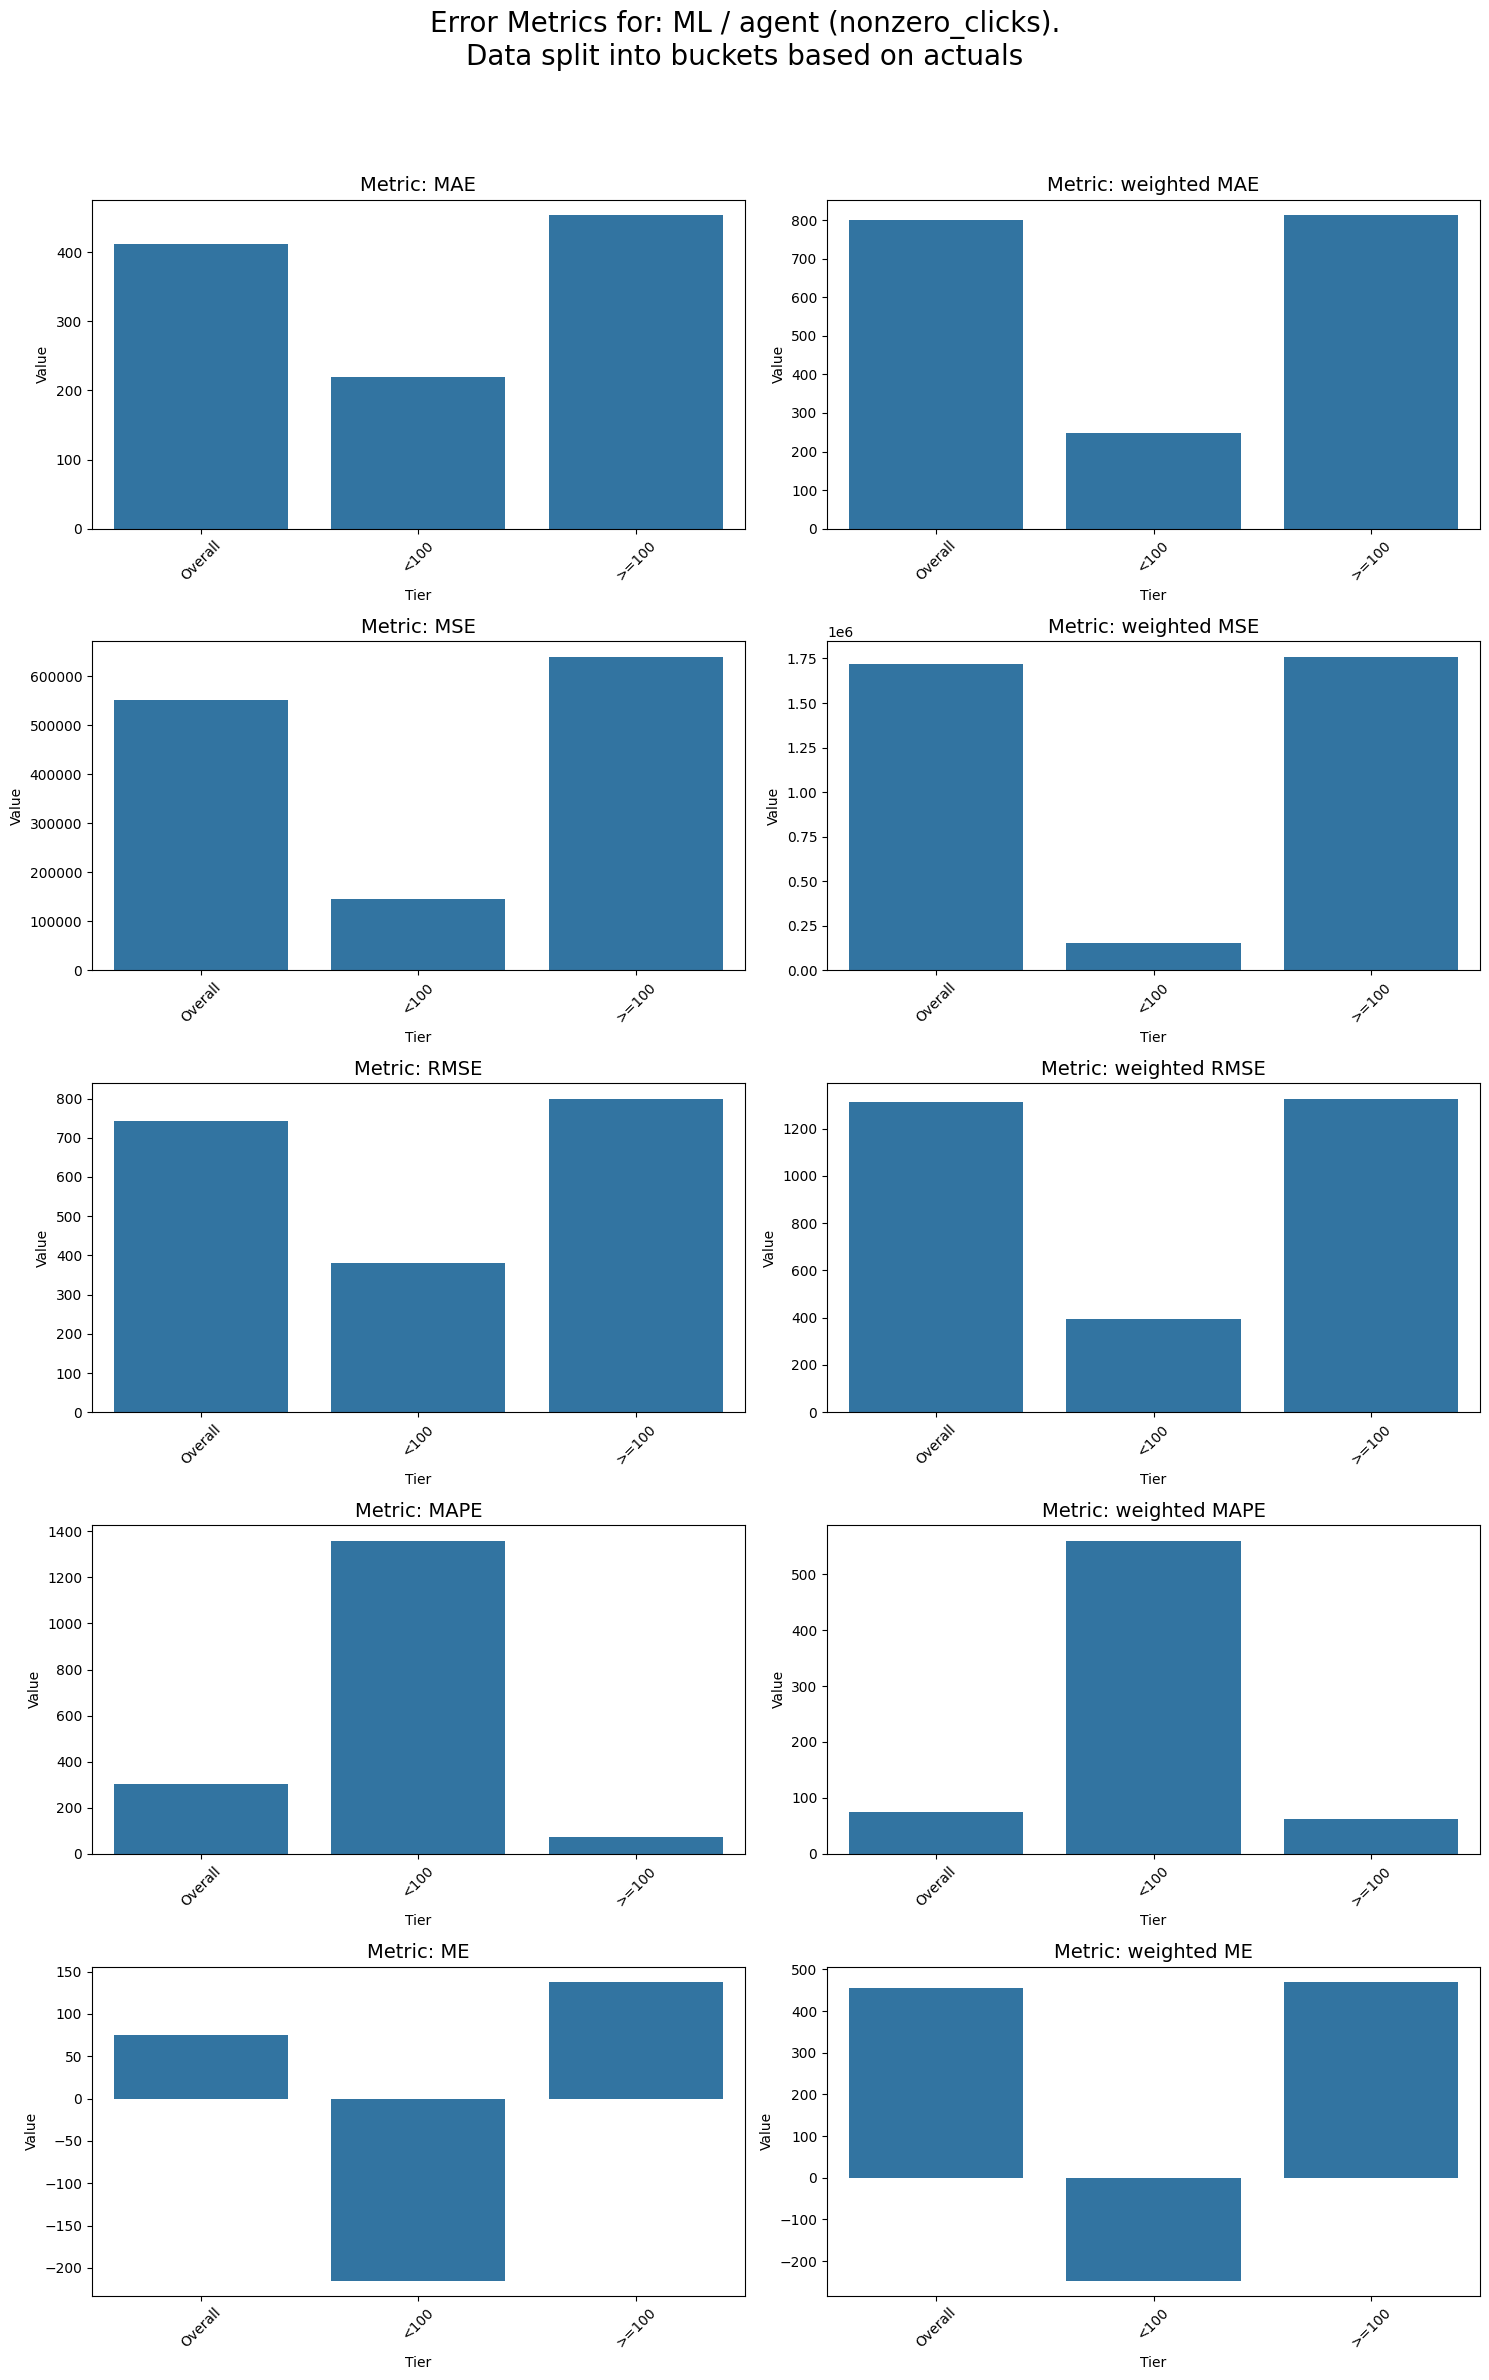

In [15]:
plot_metrics_subplots(adj_metrics_df,
                      reco_source='ML',
                      booking_source='agent',
                      data_subset='nonzero_clicks',
                      actual_cutting_column=True)

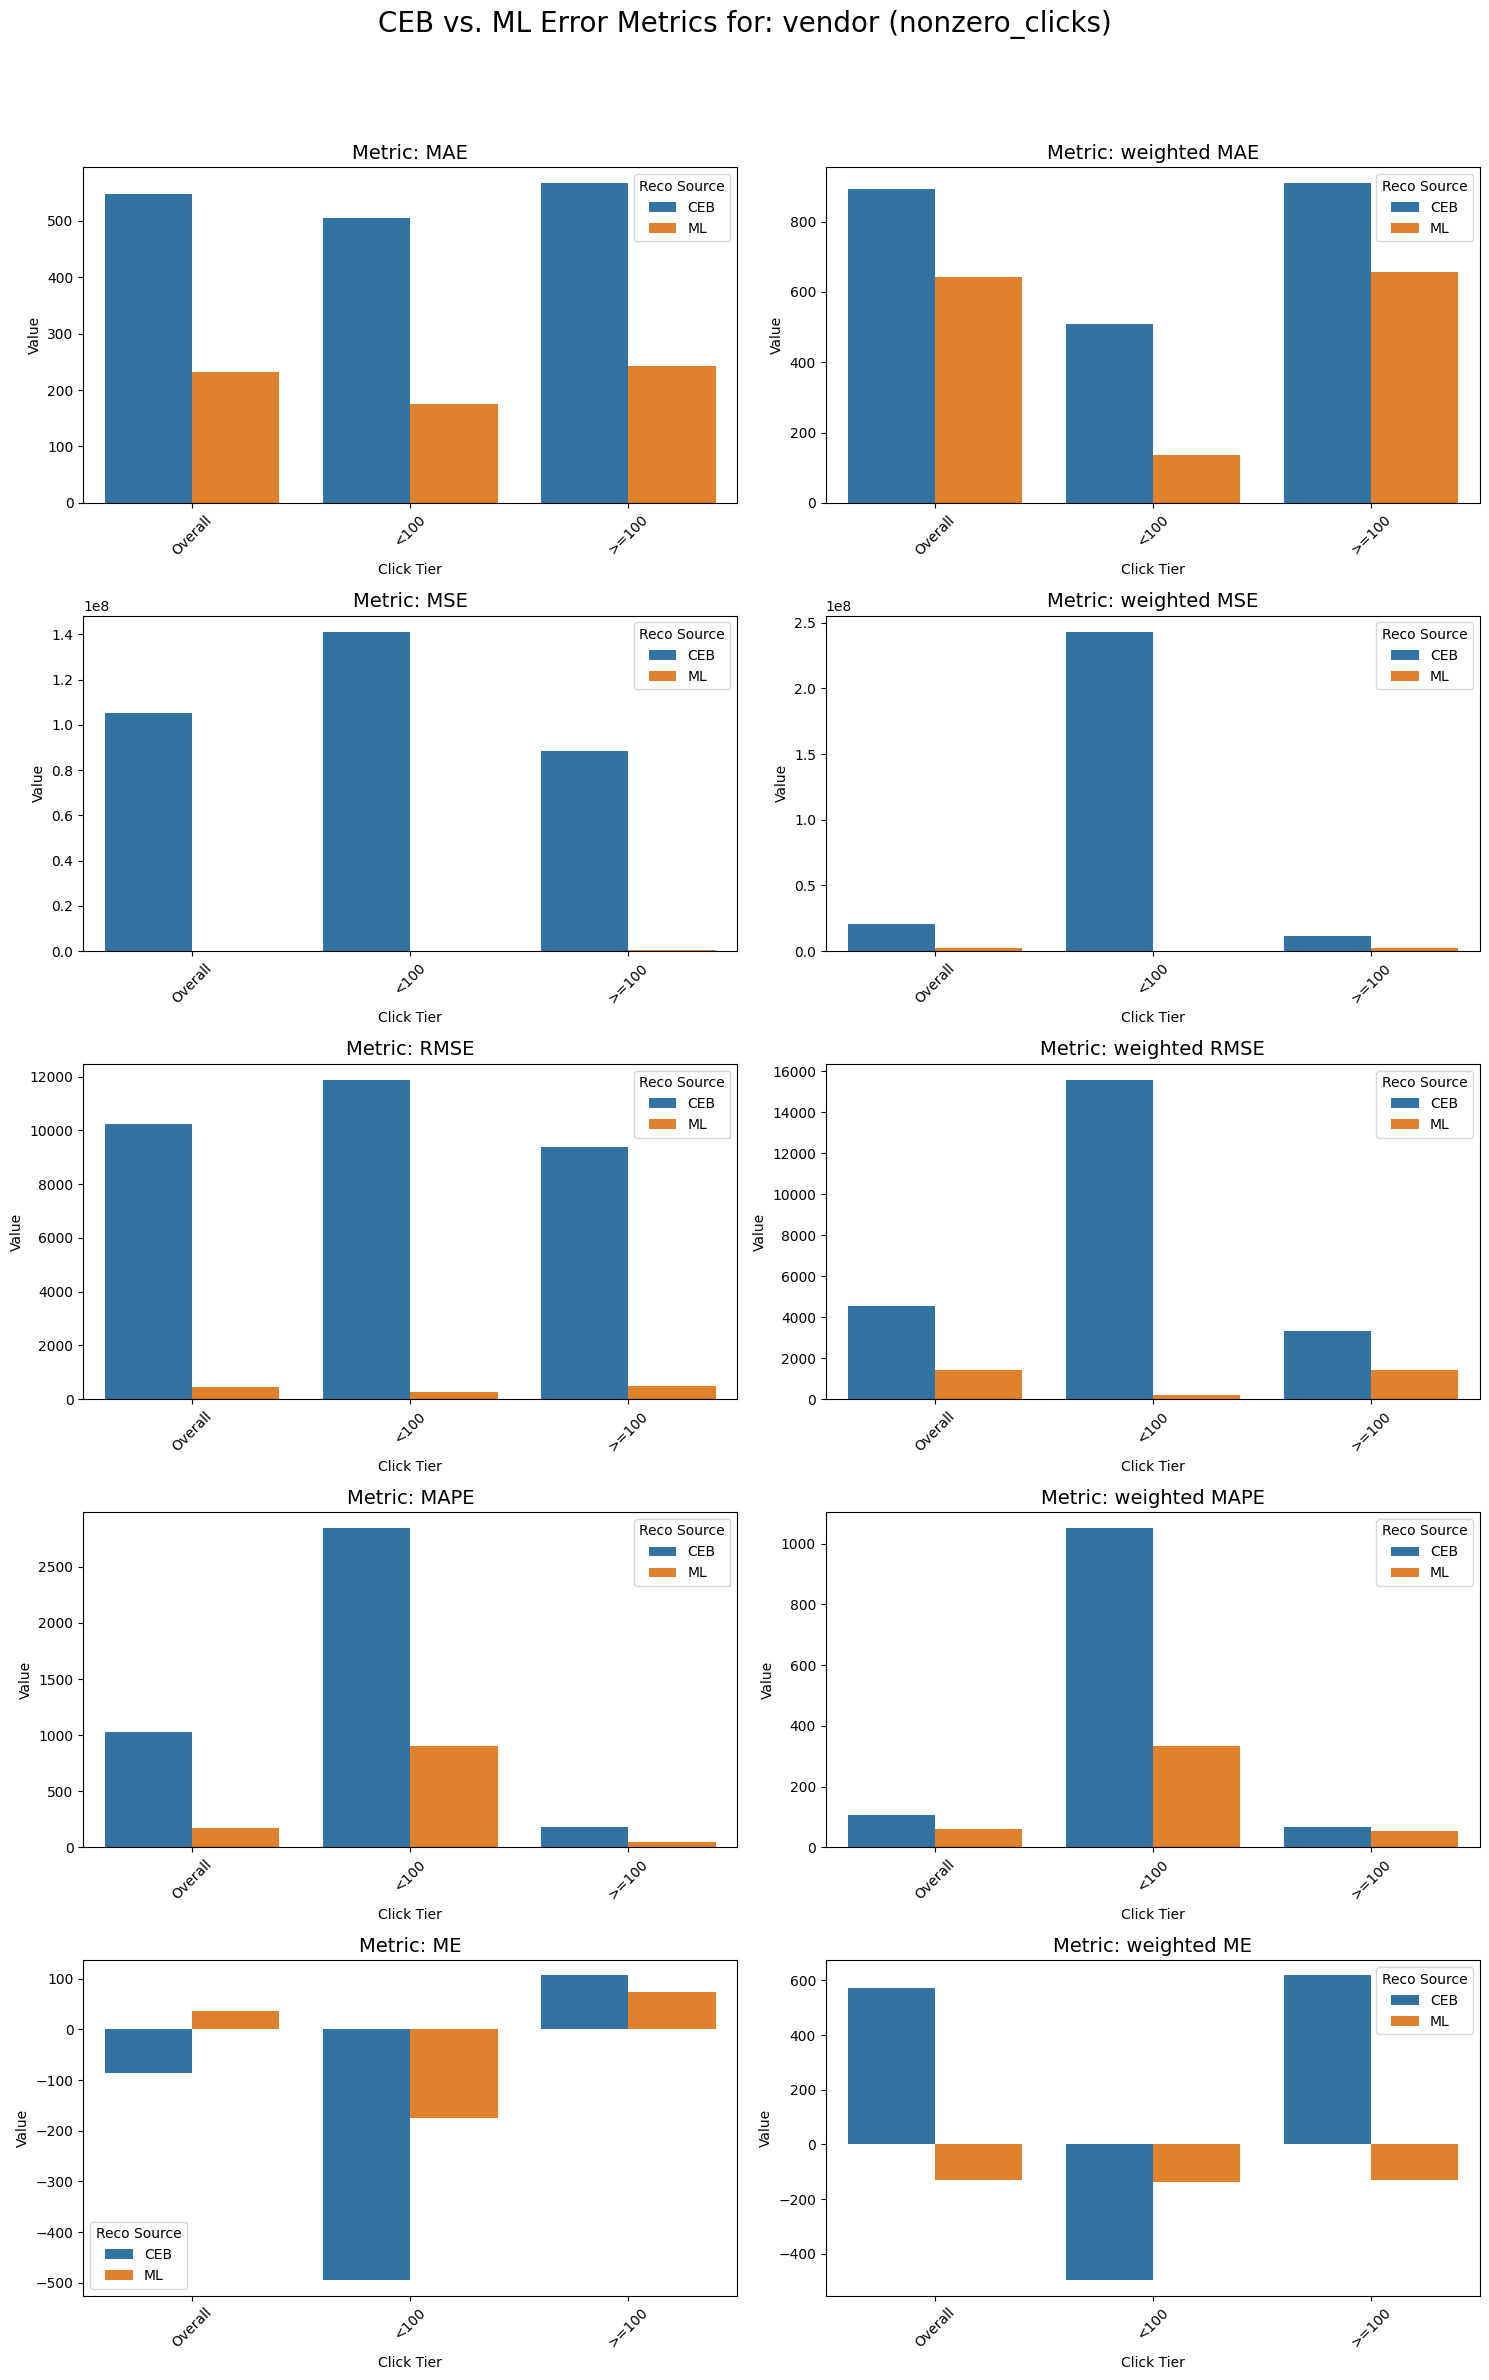

In [16]:
def plot_comparison_subplots(df, booking_source, data_subset):
    """
    Filters data for a booking_source and creates a 2x2 grid of grouped bar plots
    to compare CEB and ML reco_sources.
    """
    # Filter for the specific booking_source and data_subset, keeping both reco_sources
    plot_data = df.query(
        f"booking_source == '{booking_source}' and "
        f"data_subset == '{data_subset}'"
    )

    if plot_data.empty:
        print(f"No data found for the combination: {booking_source}, {data_subset}")
        return

    # Get the unique metrics to plot, ensuring a consistent order
    metrics_to_plot = ['MAE', 'weighted MAE', 
                       'MSE', 'weighted MSE', 
                       'RMSE', 'weighted RMSE', 
                       'MAPE', 'weighted MAPE', 
                       'ME', 'weighted ME']

    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(5, 2, figsize=(15, 25))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        metric_data = plot_data[plot_data['metric'] == metric]
        
        # Use hue='reco_source' to create grouped bars
        sns.barplot(data=metric_data, x='tier', y='value', hue='reco_source', ax=ax)
        
        ax.set_title(f'Metric: {metric}', fontsize=14)
        ax.set_xlabel('Click Tier')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Reco Source')

    fig.suptitle(f'CEB vs. ML Error Metrics for: {booking_source} ({data_subset})', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- 3. Example Usage ---
plot_comparison_subplots(adj_metrics_df,
                         booking_source='vendor',
                         data_subset='nonzero_clicks')

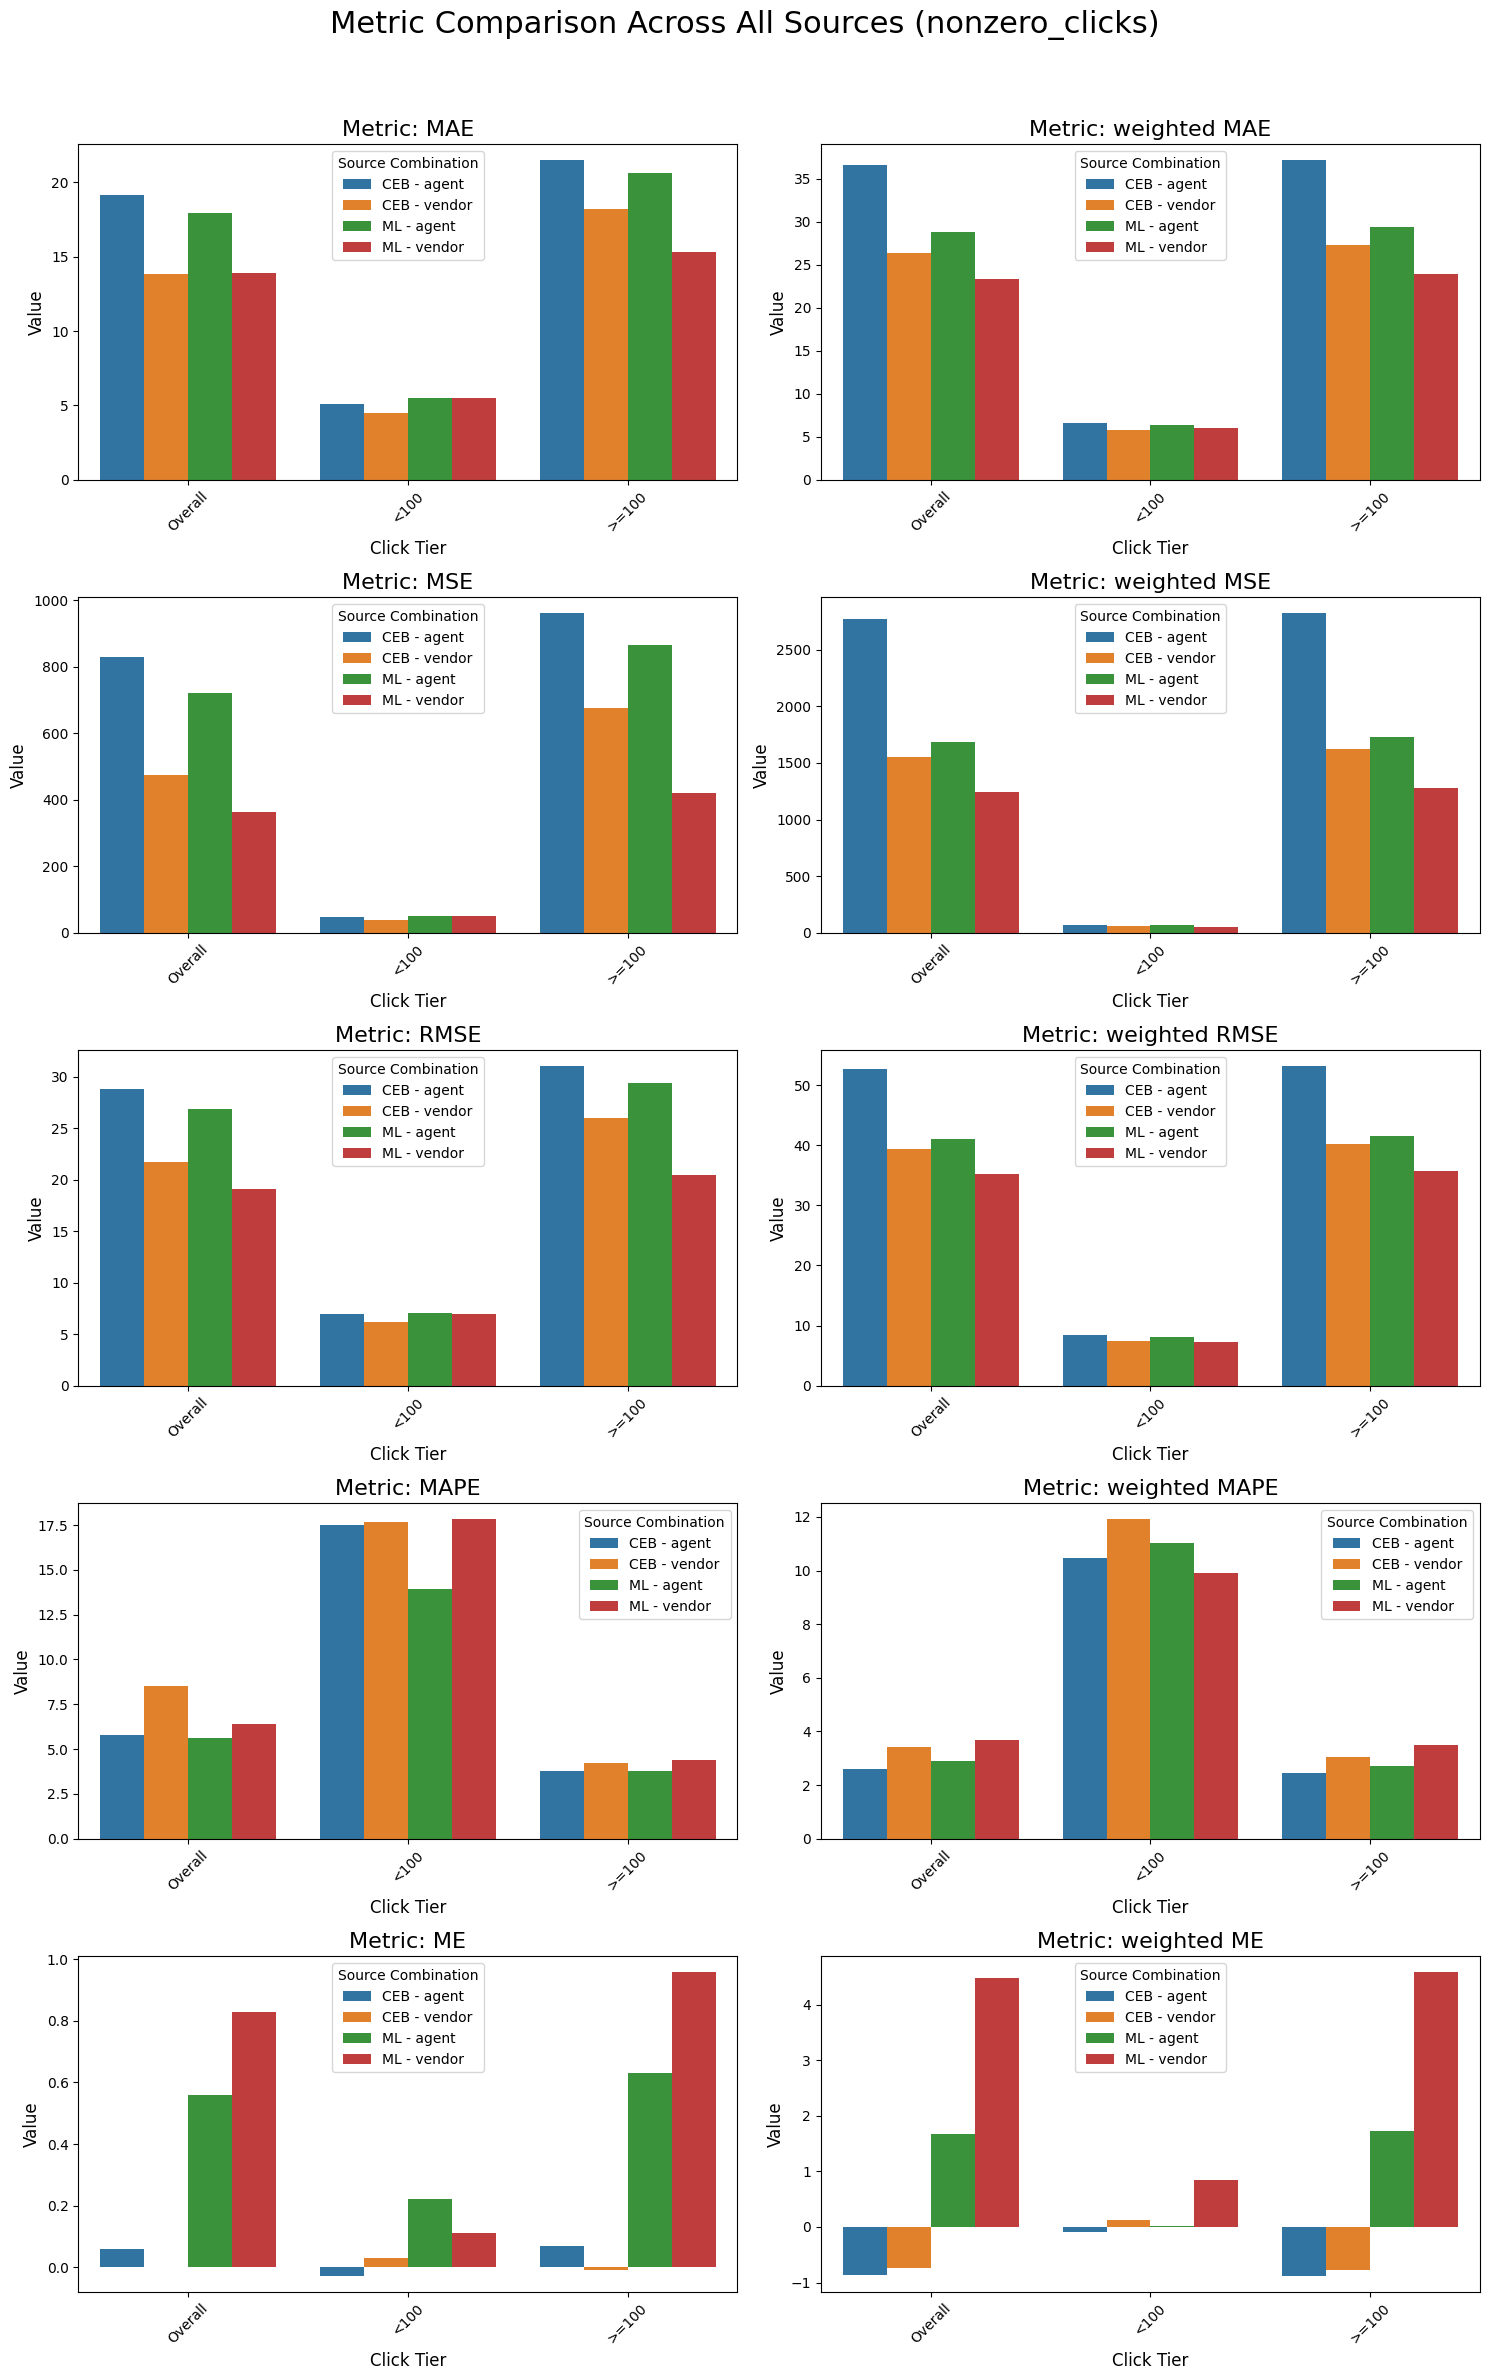

In [18]:
def plot_all_combinations_subplots(df, data_subset):
    """
    Creates a 2x2 grid of grouped bar plots to compare all combinations
    of reco_source and booking_source.
    """
    # Filter for the specific data_subset
    plot_data = df.query(f"data_subset == '{data_subset}'").copy()

    if plot_data.empty:
        print(f"No data found for data_subset: {data_subset}")
        return

    # Create a new column for the hue by combining the two source columns
    plot_data['combination'] = plot_data['reco_source'] + ' - ' + plot_data['booking_source']

    # Get the unique metrics to plot, ensuring a consistent order
    metrics_to_plot = ['MAE', 'weighted MAE', 
                       'MSE', 'weighted MSE', 
                       'RMSE', 'weighted RMSE', 
                       'MAPE', 'weighted MAPE', 
                       'ME', 'weighted ME']

    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(5, 2, figsize=(15, 25))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        metric_data = plot_data[plot_data['metric'] == metric]
        
        # Use the new 'combination' column for the hue
        sns.barplot(data=metric_data, x='tier', y='value', hue='combination', ax=ax)
        
        ax.set_title(f'Metric: {metric}', fontsize=16)
        ax.set_xlabel('Click Tier', fontsize=12)
        ax.set_ylabel('Value', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.legend(title='Source Combination')

    fig.suptitle(f'Metric Comparison Across All Sources ({data_subset})', fontsize=22)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


# --- 3. Example Usage ---
plot_all_combinations_subplots(poisson_metrics_df,
                               data_subset='nonzero_clicks')

CEB is really bad

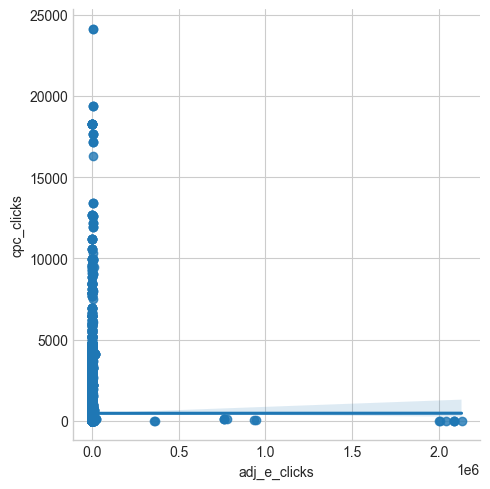

In [ ]:
tmp = df.loc[(df.booking_source == 'vendor') & (df.reco_source == 'CEB')]
sns.lmplot(data=tmp, x='adj_e_clicks', y='cpc_clicks')


In [ ]:
tmp.sort_values(by='adj_e_clicks', ascending=False).head(10)

,reco_source,booking_source,global_entity_id,vendor_id,date_month,management_entity,campaign_id,booked_budget,cpc_clicks,cpc_orders,...,k_c,b_c,k_o,b_o,k_r,b_r,adj_e_clicks,adj_e_orders,adj_e_roas,poisson_clicks
8853,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.804348,-2.173913,0.456522,-1.260870,0.0,3.0,2.128527e+06,255422.195652,3.0,0
10882,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.723404,-2.659574,0.446809,-1.319149,0.0,3.0,2.083238e+06,249987.595745,3.0,0
9037,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.723404,-2.659574,0.170213,0.021277,0.0,3.0,2.083238e+06,95233.893617,3.0,0
10296,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.723404,-6.382979,0.446809,-1.765957,0.0,3.0,2.083235e+06,249987.148936,3.0,0
7501,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.645833,0.520833,0.437500,-0.937500,0.0,3.0,2.039841e+06,244779.875000,3.0,0
10138,CEB,vendor,FP_TW,p7lo,2025-06-01,Foodpanda APAC,683bf90c31de582dd6aa4e40,442277.000000000,0,0,...,4.528986,-48.188406,0.753623,-7.898551,0.0,3.0,2.003018e+06,333302.304348,3.0,0
9586,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.571429,0.000000,0.428571,-1.000000,0.0,3.0,1.998211e+06,239784.285714,3.0,0
13657,CEB,vendor,HS_SA,130003,2025-06-01,HungerStation,6845afb9633cc7bebffb40eb,468021.000000000,64,4,...,2.016129,-27.419355,0.100806,-2.370968,0.0,3.0,9.435633e+05,47177.165323,3.0,60
13517,CEB,vendor,HS_SA,130003,2025-06-01,HungerStation,6845afb9633cc7bebffb40eb,468021.000000000,64,4,...,1.992032,-28.286853,0.099602,-2.414343,0.0,3.0,9.322845e+05,46613.223108,3.0,61
3963,CEB,vendor,FP_MY,vj0e,2025-06-01,Foodpanda APAC,683f9cef0329005845388a51,87629.000000000,114,7,...,8.870968,-25.000000,0.387097,-1.000000,0.0,3.0,7.773290e+05,33919.903226,3.0,110


In [ ]:
max_clicks = tmp.cpc_clicks.max()
# how many rows are greater than five times this?
outliers = tmp.adj_e_clicks >= max_clicks * 5
tmp.loc[outliers].shape[0]


15

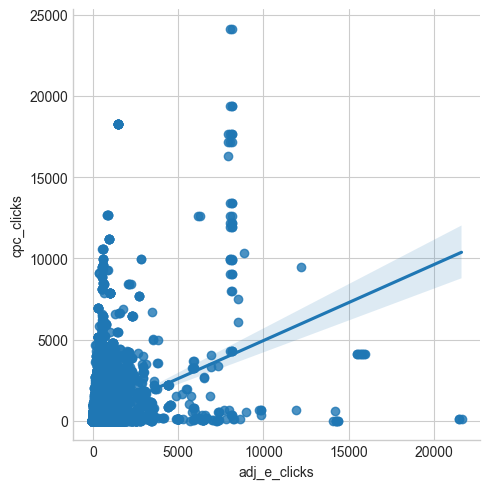

In [ ]:
sns.lmplot(data=tmp.loc[tmp.adj_e_clicks <= max_clicks * 5], x='adj_e_clicks', y='cpc_clicks')